# Excess Mortality Analysis

In this notebook we will attempt to calculate the excess deaths in Germany during the COVID-19 epidemic. We base our analysis on the dataset of weekly deaths since 2000 in Germany obtained from eurostat. Based on the trend and periodogram of the time series we generate numerical features that capture the temporal structure of the deaths in Germany enabling us to train and compare various machine learning algorithms that can then be used to predict the mortality of the time period starting from 2020 in the absence of corona. 
This prediction can then be compared to the actual mortality yielding an estimation for the number of excess deaths during the COVID-19 pandemic.

## 1. Data and relevant Libraries
We conduct our analysis using Python. The main libraries used are`scipy` which we use to analyze the seasonality of the weekly deaths, `statsmodels` for generating the temporal features used in our machine learning pipeline which itself is based `scikit-learn` and `matplotlib` for visualizing our results. Besides that we also use `pandas` and `numpy` to perform some auxillary tasks.

The data comes from [EuroStat](https://ec.europa.eu/eurostat/data/database) as an excel table containing the weekly Deaths in Germany from 2000 until now (March 2022). The preprocessing of this data is done in the `Analytics` module by the function `eurostats_loader` which returns the data as a pandas DataFrame 

In [2]:
from Analytics import eurostats_loader
import pandas as pd
import numpy as np
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram, detrend
from sklearn.linear_model  import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Adjust color cycle of plots (first line HS-blue second line burgundy red, turqouise)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#0645ad", "#800020", "#1EB9E7", ]) 
mpl.rcParams['figure.dpi'] = 100

## 2. Preparing the Data.
We discard all observations before 2008 since including them would distort the trend estimation for our model due to the fact that the demography or Germany is undergoing significant changes, since 2008 the mortality has been increasing linerarly specifically. 

The preprocessed data is then split into a training-, validation- and test-set. We use a validation set for comparing model performace. The test set contains the periods from 2020 onward, hence the time period since COVID-19 started to spread.

In [36]:
Weekly_Deaths = eurostats_loader("Germany Weekly Total Deaths")
Weekly_Deaths = Weekly_Deaths[Weekly_Deaths.index.year >= 2008]

Weekly_Deaths_train = Weekly_Deaths[Weekly_Deaths.index.year < 2019]
Weekly_Deaths_val = Weekly_Deaths[Weekly_Deaths.index.year == 2019]
Weekly_Deaths_test = Weekly_Deaths[Weekly_Deaths.index.year > 2019]

Text(0.5, 1.0, 'Weekly Deaths in Germany 2000-2022')

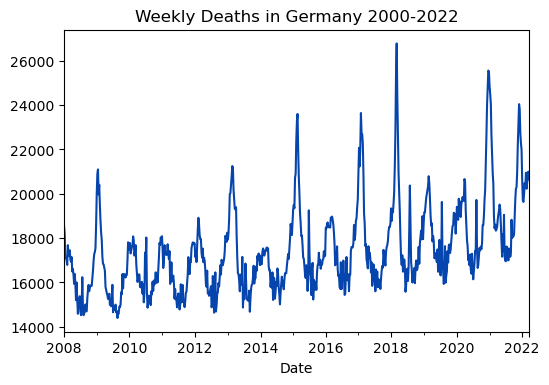

In [5]:
Weekly_Deaths.Value.plot().set_title("Weekly Deaths in Germany 2000-2022")

## 3. Analyzing seasonality
A visual inspectation of `Weekly_Deaths` gives evidence for the existence of a seasonal pattern in the mortality. In general seasonal patterns can be modeled via sine and cosine periodic functions. The mathematical theory of Fourier Analysis provides tools for finding the periodic functions that best model the seasonality of our data. The `periodogram` function from scipy is one such tool. By mapping the time series from its representation in the time domain (x-axis) to a domain (x-axis) of frequencies where peaks indicate that a sine or cosine function with the corresponding frequency models a part or the entire seasonality of the time series.

<figure>
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/7/72/Fourier_transform_time_and_frequency_domains_%28small%29.gif"/>
<figcaption style="color:white;font-size:10px;" face="Droid Sans">Visual Intuition behind the Periodogram. </figcaption>   
</center>
<figure>

In addition to the time series to be mapped, we can set the frequency domain to which it will be mapped via the argument `fs`. By setting fs to be equal to the number of weeks per year scale the frequency domain such that one year is equal to a frequency of one. For the periodogram to be accurate the time series needs to be stationary which can be achieved by detrending it beforehand. The type of trend can be set via the `detrend` argument, to us a linear trend seems to be an appropriate choice. Setting the argument `scaling` to `"spectrum"` makes sure that the following equality is fulfilled:

$$ \operatorname{Var}(X)=\int_{-\infty}^{\infty} S_{x x}(f) d f \hspace{1cm}(3.1)$$

where $X$ are the values of the time series and $f$ the frequencies returned by `periodogram`. The function $S_{x x}(f)$ is the so-called power spectrum which due to the above equation can be interpreted as the amount of variance of the times series explained by each frequency $f$. Note that due to the fact that $f$ returned by the periodogram is discrete the integration turns into summation.

In [6]:
fs = pd.Timedelta("1Y") / pd.Timedelta("1W")
print(f"fs: {fs}\n")
f, Sxx = periodogram(Weekly_Deaths_train.Value, detrend="linear", fs=fs, scaling="spectrum")
# The Power Spectrum Sxx indicates the share of each frequency of the variance of the Time Series.
print("Is equation (3.1) fulfilled?\n")
print(f"Sxx: {np.sum(Sxx)}")
# Weekly Deaths need to be detrended because the periodogram is fitted on the detrended series.
print(f"Var: {np.var(detrend(Weekly_Deaths_train.Value))}\n")
# Peak of periodogram
print(f"Peak frequency: {f[np.argmax(Sxx)]}")

fs: 52.1775

Is equation (3.1) fulfilled?

Sxx: 2622874.129926565
Var: 2622874.129926564

Peak frequency: 0.9999172473867595


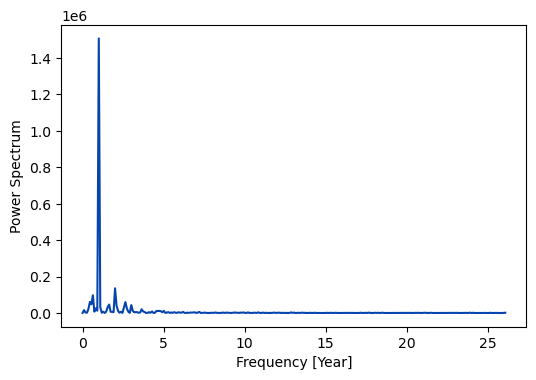

In [5]:
plt.plot(f, Sxx)
plt.xlabel('Frequency [Year]')
plt.ylabel('Power Spectrum')
plt.show()

## 4. Generating temporal Features
In this section we create features for our machine learning models. Although it would be feasible to take the entire time axis of the time series `Weekly Deaths` as feature vector this would force us to use a highly complex model because it would need to deduce seasonality and trend together from time dates alone. Due to the fact that the time series appears to have a trend and periodogram analysis in section 3 gave overwhelming evidence for yearly seasonality we decided to directly handcraft these features since this enhances the explainability of our models which is crucial in a medical context.

The function `DeterministicProcess` from statsmodels is used to generate features for each component of our time series. DeterministicProcess will generate features for the three components we use to model our time series, namely the average of the series or its *level*, its trend and its seasonality. Although DeterministicProcess has the argument `fourier`, we decide to create the periodic features ourselves via `CalendarFourier` since it enables us to control the frequency of the functions. After comparing model performance for the models using the fourier features for different values of `order` in CaldendarFourier we decided to set it to 3. This gives the model enough flexibility to adapt to the not entirerly sinosoidal shape of the peaks of the time series. Inspired by the paper by Kalinsky and Kobak (see sources) we decided to also add dummy variables for the weeks in order to have an alternative way to model the seasonal patterns in the data.

In [7]:
fourierA = CalendarFourier(freq="A", order=3)


y_train = Weekly_Deaths_train.Value

dp = DeterministicProcess(index=y_train.index.to_period("W"),
                          constant=True,               # dummy feature for bias (y-intercept)
                          seasonal=True,
                          order=1,                     # trend (order 1 means linear)
                          additional_terms=[fourierA],) # annual seasonality (fourier)


X_train = dp.in_sample()

val_index = Weekly_Deaths_val.index
X_val = dp.out_of_sample(len(val_index), val_index)

# True values of the times series for the training and testing time frames.
y_train_true = Weekly_Deaths_train.Value
y_val_true = Weekly_Deaths_val.Value

For a more closer look at the features generated by `dp.in_sample()` run the cells below.

In [22]:
list(X_train.columns[53:])

['sin(1,freq=A-DEC)',
 'cos(1,freq=A-DEC)',
 'sin(2,freq=A-DEC)',
 'cos(2,freq=A-DEC)',
 'sin(3,freq=A-DEC)',
 'cos(3,freq=A-DEC)']

Text(0.5, 1.0, 'Sine Features')

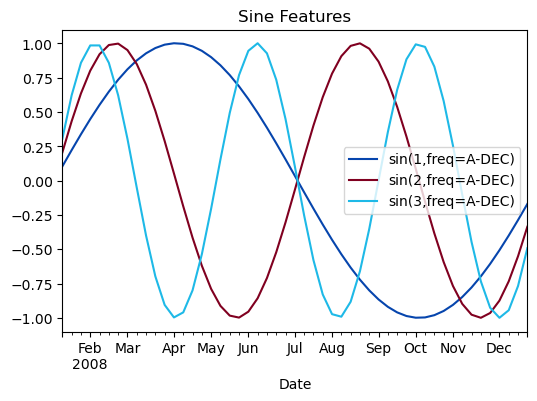

In [22]:
X_train[["sin(1,freq=A-DEC)", "sin(2,freq=A-DEC)", "sin(3,freq=A-DEC)"]].loc[X_train.index<"2009"].plot().set_title("Sine Features")

## 5. Fit Models
We fit and compare the performance of two models on the training data `D = (X_train, y_train)` containing the time series components as features and the Weekly Deaths until 2020 as predicted variable. In essence the models try to combine the components generated by `DeterministicProcess` in such a way that their sum looks like `y_train`. While Linear Regression is a well known technique the second algorithm we used might not be familiar to everyone. We also had to decide which loss function to use to measure the *goodness of fit* of our models and make asses the trade-off between performance and interpretability. In Addition to the two models based on all the features we train a linear regression model on only `"const"` and the `"trend"` features of `X_train` to have a simple model as benchmark.

### 5.1. Gradient Boosting
The idea behind Gradient Boosting is the stepwise combination of so called weak learners into an ensemble of models whose aggregate predictions are comparable to those of a more complex model. In our case the weak learners are *decision stumps* meaning decision trees with only one node. Gradient boosting works by calculating the gradient of the loss function after adding a new decision stump to the ensemble and then fitting a new decision stump to it, this procedure is repeated `n_estimator` of times. It can be thought of as a form of regularized gradient descent which prevents the model from overfitting by simply matching the data exactly since each decision stump is trained on the entire training data `D`. 

### 5.2. Evaluating the Models

We chose the *mean squared error* (mse) as loss function to measure the goodness of fit of our models. One advantage of the mse is that it penalizes large deviations from the true value while being lenient on small deviations. In the context of excess mortality prediction this makes sense since it isn't to important to get the number of deaths exactly right but rather to approximate them sufficiently well. For better interpretability of the performance we judge the model performance by the absolute error instead of the mse. A model that has a lower absolute error also has a lower mse. In the plot below it can be seen that `GradientBoostingRegressor` has roughly 10% lower absolute error than `LinearRegression`. It would be of interest to find a way to measure the statistical significance of such a performance improvement. It would also be interesting to try to come up with an evaluation strategy that uses more than one validation set, unfortunately the temporal structure of or data prevents us from using cross-validation for more accurate performance assesment.

### 5.3. Which Model to choose?
In the end we have to decide which model to use not only based on its performance but also based on its interpretability. Although `LinearRegression` is not alot worse than `GradientBoostingRegressor` and has a far superior interpretability, we have yet to find a scientific article that used `GradientBoostingRegressor` for excess mortality prediction. For the sake of novelty we therefore chose to calculate the excess mortality for 2020-2022 via our Gradient Boosting model.

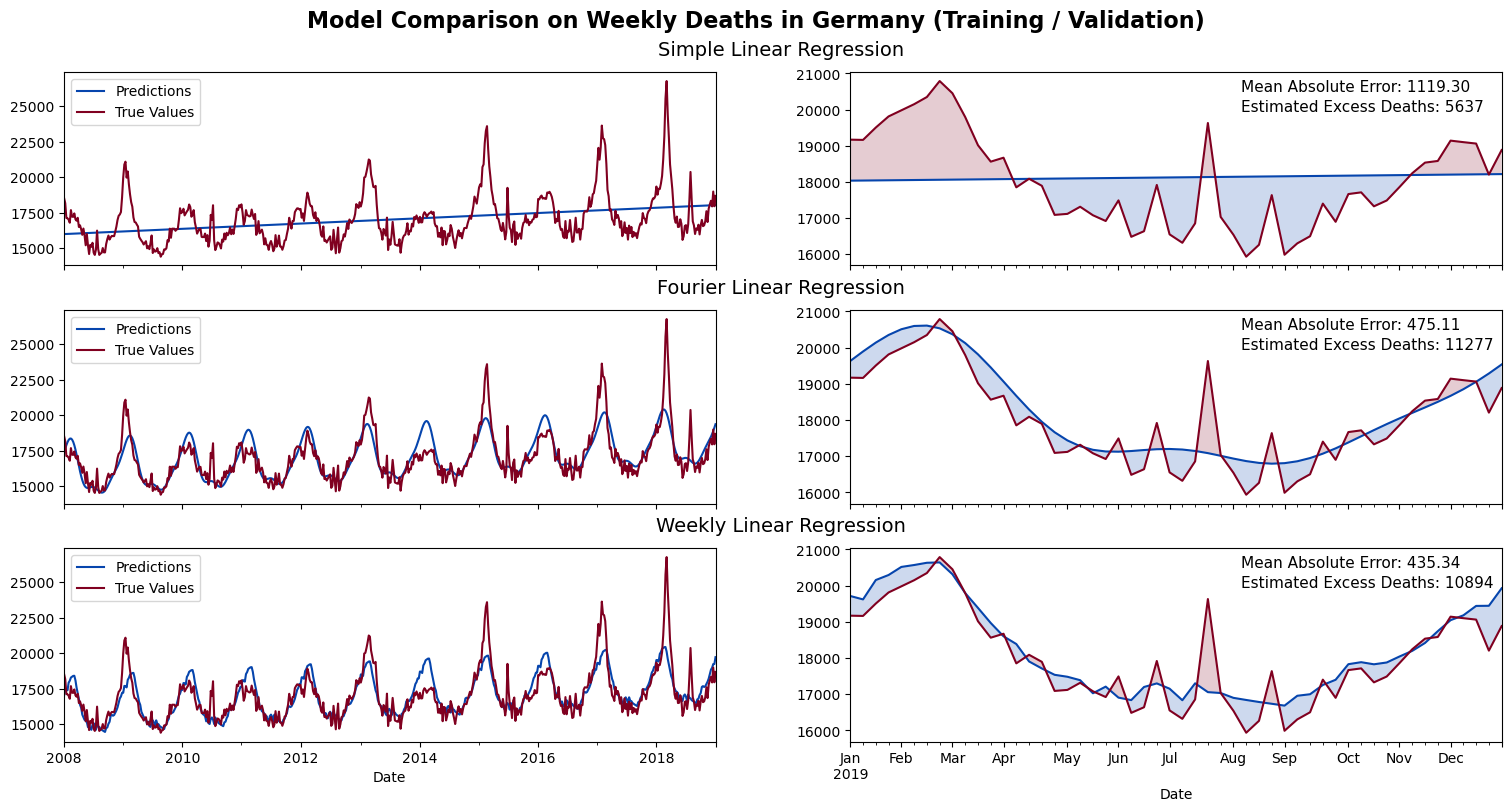

In [34]:
Models_Names = [(LinearRegression(fit_intercept=False), "Simple Linear Regression"),
                (LinearRegression(fit_intercept=False), "Fourier Linear Regression"),
                (LinearRegression(fit_intercept=False), "Weekly Linear Regression"),
                #(GradientBoostingRegressor(max_depth=1, n_estimators=150), "Fourier Gradient Boosting Regressor"),
                #(GradientBoostingRegressor(max_depth=2, n_estimators=150), "Weekly Gradient Boosting Regressor")
               ]

num_models = len(Models_Names)
fig, axes = plt.subplots(num_models,2,layout="constrained",sharex="col",figsize = (15,8))

for i, model_name_pair in enumerate(Models_Names):
    model = model_name_pair[0]
    model_name = model_name_pair[1]
           
    # Fit models
    if model_name == "Simple Linear Regression":
        Cols = ["const", "trend"]
    elif model_name in ["Weekly Linear Regression","Weekly Gradient Boosting Regressor"]:
        # Columns are const, trend + week dummies.
        Cols = ["const", "trend"] + list(X_train.columns[2:52])
    else:
        # Columns are const, trend + fourier features.
        Cols = ["const", "trend"] + list(X_train.columns[53:])
        
    model.fit(X_train[Cols],y_train)
    
    # Make predictions and determine mean absolute error.
    y_train_pred = pd.Series(model.predict(X_train[Cols]).reshape(-1), index=y_train.index)
    y_val_pred = pd.Series(model.predict(X_val[Cols]).reshape(-1), index=val_index)
    mean_abs_err = np.mean(abs(y_val_pred - y_val_true))
    sum_blue_red_area = np.sum(y_val_pred - y_val_true)
    
    ax_train = axes[i,0]
    ax_train.set_title(f"{model_name}", y=1.05,x=1.1, pad=5, size=14)
    y_train_pred.plot(ax=ax_train, label="Predictions")
    y_train_true.plot(ax=ax_train, label="True Values")
    ax_train.legend()
    
    # Plot results for the validation set.
    ax_val = axes[i,1]
    y_val_pred.plot(ax=ax_val)
    y_val_true.plot(ax=ax_val)
    ax_val.axes.annotate(f"Mean Absolute Error: {mean_abs_err:.2f}", xy=(0.6,0.9), xycoords='axes fraction', fontsize=11)
    ax_val.axes.annotate(f"Estimated Excess Deaths: {sum_blue_red_area:.0f}", xy=(0.6,0.8), xycoords='axes fraction', fontsize=11)
    ax_val.fill_between(y_val_true.index,y1=y_val_true , y2=y_val_pred, where=y_val_true <= y_val_pred, facecolor='#0645ad', alpha=0.2,interpolate=True)
    ax_val.fill_between(y_val_true.index,y1=y_val_true , y2=y_val_pred, where=y_val_true >= y_val_pred, facecolor='#800020', alpha=0.2,interpolate=True)

plt.suptitle("Model Comparison on Weekly Deaths in Germany (Training / Validation)", fontsize="16",fontweight="bold")  
plt.savefig("Comparison of Linear Regression Models.png", dpi = 200)

## 6. Analyze Residuals
The term *residual* describes the difference between the value of the time series at a time step $t$ and the prediction of the model for that time step.

$$ \text{residuals}(t) = \text{TimeSeries}(t) - \text{Predictions}(t)\hspace{1cm}(6.1)$$

### 6.1. Partial Autocorrelation
We have already looked at the mean squared error and absolute error in the preceding section, so why is this quantity still of interest? It turns out that for modeling confidence intervals, we need the residuals to be uncorrelated. This isn't the case unfortunately, which we can show by generating the *partial autocorrelation* plot of the residuals. Before we explain what the partial autocorrelation is, let's look at the *autocovariance* first. For our time series of residuals `residuals` the autocorrelation is defined based on the autocovariance function $r$.

$$ r(s) = \text{Cov}(\text{residual}(t), \text{residual}(t-s))\hspace{0.5cm}{\forall} s,t\in\mathbb{N}\hspace{1cm}(6.2)$$

The function $r(s)$ let's us calculate the covariance of the time series at time step $t$ with itself at time step $t-s$ or lag $s$.  Note that $r( )$ doesn't depend on $t$ so we assume that the autocovariance only depends on the number of timesteps between the two arguments of the function and not the specific value of $t$. Based on this definition, the autocorrelation can be defined as 

$$\rho(s) = \dfrac{r_s}{r_0}\hspace{1cm}(6.3)$$

Now the problem with this function is that the autocorrelation between the time series and its $s$-th lag might be influenced by all the lags in between from one to $s-1$. This is where the partial autocorrelation comes into play which is calculated by isolating the direct influence lag $s$ has on the time series from its influence via the other lags in between. Plotting and calculating the partial autocorrelation or *pacf* can be done in Python via the `plot_pacf` function from the `statsmodels` library. The partial autocorrelations are calculated via an approach based on (ordinary) linear regression, which for conciseness we won't further discuss here.

### 6.2. Residual Histogram
Since the correlation implies dependence, we can't use techniques such as *kernel density estimation* to get an estimation of the probability density function which generates the residuals. We can still however use histograms to get an idea of the statistical properties of the residuals. Our histogram plot shows that the residuals are centered around zero, which suggests that our model has correctly inferred the underlying level and trend of the time series properly.

Looking at the distributions of the bins of the histograms shows a strong deviation from symmetry due to a long tail of positive values. This means that our residuals are most likely not normally distributed, hence many theoretical results and guarantees won't apply to our model. 

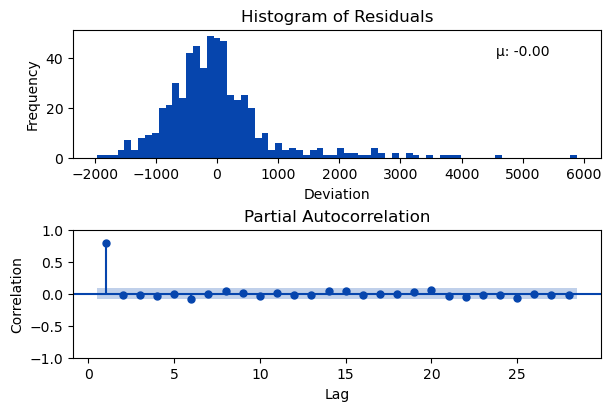

In [31]:
#%% Analyze Residuals.
residuals = Weekly_Deaths_train.Value - y_train_pred # Residuals (see 6.1)
# Prepare plot.
fig, ax = plt.subplots(2,1, layout="constrained")
ax[0].axes.annotate(f"μ: {residuals.mean():.2f}", xy=(0.8,0.8), xycoords='axes fraction', fontsize=10)
ax[0].set_xlabel("Deviation")
ax[1].set_ylabel("Correlation")
ax[1].set_xlabel("Lag")
# Plot pacf and residual histogram.
plot_pacf(residuals, ax=ax[1], method='ols', zero=False)  
residuals.plot(ax=ax[0], kind="hist", bins=70).set_title("Histogram of Residuals")
plt.savefig("AnalysisResiduals.png", dpi=200)

### 6.3. Conclusion
Since our residuals are correlated, there seems to be some information in the data that our model hasn't captured. This means that there is room for improvement for our predictions. In order to harness the correlation of the time series with its lags, we looked into the theory of time series, specifically AR and SARIMA processes, in order to build a new model that can incorporate autocorrelations of the time series. Getting rid of the correlation will also enable us to generate sensible confidence intervals for our predictions. The following points summarize the content of this section:

<span style="color:grey;font-weight:500;font-size:12px">
<ul style="line-height:200%">
  <li>Residuals are the difference between the true values of a time series and their predictions by the model.</li>  
  <li>The partial autocorrelation describes the correlation between a time series and its lags, accounting for the    correlations between the lags themselves.</li>
  <li>The histogram indicates an asymmetric distribution of the residuals centered around zero.</li>  
  <li>The model doesn't capture all the information available in the data due to remaining correlation. </li>
</ul>
</span>

## 7. Excess Mortality Estimation
We now use our Gradient Boosting model to estimate the number of excess deaths between the start of 2020 and March 2022 in Germany. Our model estimates roughly $131000$ excess deaths in comparisson to two "normal" years with winterly influenza waves. 

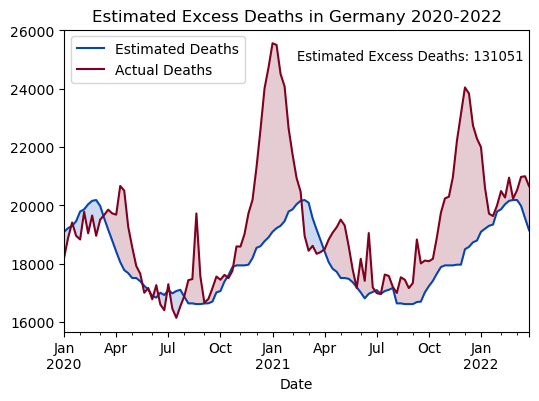

In [20]:
model = GradientBoostingRegressor(max_depth=1)

# Generate features and labels to train the model.
y_comb_train = Weekly_Deaths[Weekly_Deaths.index.year < 2020] # Former validation set will be added to the training set.

dp = DeterministicProcess(index=y_comb_train.index.to_period("W"),
                          constant=True,                # dummy feature for bias (y-intercept)
                          order=1,                      # trend (order 1 means linear)
                          additional_terms=[fourierA],)  # annual seasonality (fourier)

X_comb_train = dp.in_sample() # Generate features for model.

# Fit and predict step.
model.fit(X_comb_train, y_comb_train)

test_index = Weekly_Deaths_test.index
X_test = dp.out_of_sample(len(test_index), test_index)
y_test = pd.Series(model.predict(X_test).reshape(-1), index=test_index)

excess_deaths = np.sum(Weekly_Deaths_test.Value-y_test)

# Plot results.
fig_test, ax_test = plt.subplots()
ax_test.axes.annotate(f"Estimated Excess Deaths: {excess_deaths:.0f}", xy=(0.5,0.9), xycoords='axes fraction', fontsize=9.5)
y_test.plot(ax=ax_test, label="Estimated Deaths")
Weekly_Deaths_test.Value.plot(ax=ax_test, label="Actual Deaths").set_title("Estimated Excess Deaths in Germany 2020-2022")
ax_test.fill_between(y_test.index,y1=y_test , y2=Weekly_Deaths_test.Value, where=Weekly_Deaths_test.Value <= y_test, facecolor='#0645ad', alpha=0.2,interpolate=True)
ax_test.fill_between(y_test.index,y1=y_test , y2=Weekly_Deaths_test.Value, where=Weekly_Deaths_test.Value >= y_test, facecolor='#800020', alpha=0.2,interpolate=True)
ax_test.legend(loc="upper left")


## 7. Sources
1. Hastie, T., Tibshirani, R., Friedman, J. (2009). The elements of statistical learning: data mining, inference and prediction. Springer.
2. Ashbacher, C. (2005). All the Mathematics You Missed (But Need to Know for Graduate School). School Science and Mathematics
3. Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. https://otexts.com/fpp2/. Accessed on <01.05.2022>.
4. Redenbach, C. (2020). Lecture Notes - Regression and Time Series Analysis. TU Kaiserslautern SS20.
5. Arens, T. Hettlich, F., Karpfinger, C., Kockelkorn, U., Lichtenegger, K., Stachel, H. (2018). Mathematik. Springer
6. Holbrook, R., Cook, A. (07.05.2022) *Time Series*. Kaggle. https://www.kaggle.com/learn/time-serie
7. A Karlinsky, D Kobak - Elife, 2021, Tracking excess mortality across countries during the COVID-19 pandemic with the World Mortality Dataset